# Titanic example

In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from toolbox import DataFrameImputer, BinaryEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

import xgboost as xgb

from category_encoders import SumEncoder

from sklearn.pipeline import FeatureUnion

# Read data in

In [181]:
df = pd.read_csv('train.csv').set_index('PassengerId')
df_validation = pd.read_csv('test.csv').set_index('PassengerId')

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [183]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [106]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [107]:
df[['Survived']].head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [108]:
#df['Ticket1'] = df.Ticket.apply(lambda x: len(x.split()))

In [171]:
regex = r"(?P<Forename>.+), (?P<Title>.+)\. (?P<Lastname>.+)"
regex = r".+, (?P<Title>.+)\. .+"

regex = r", (?P<Title>.+?)\."
df_validation['Title'] = df_validation.Name.str.extract(regex, expand=False)
df['Title'] = df.Name.str.extract(regex, expand=False)

print(df_validation.Title.unique())
print(df.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


In [180]:
title_order = {
    # Dying
    'Capt': 0,
    'Rev': 0,

    # Ordinal male
    'Master': 1,
    'Mr': 1,
    'Don': 1,

    # educated  or military
    'Dr': 2,
    'Col': 2,
    'Major': 2,

    # Ordinal female
    'Miss': 1,
    'Mrs': 1,
    'Ms': 1,
    'Dona': 1,

    # Nobels
    'Jonkheer': 2,
    'Mme': 2,
    'Sir': 2,
    'Lady': 2,
    'Mlle': 2,
    'the Countess': 2,
}

df['Title1'] = df.Title.map(title_order)
df_validation['Title1'] = df_validation.Title.map(title_order)

print(df.Title.unique())
print(df_validation.Title.unique())


print(df.Title1.unique())
print(df_validation.Title1.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
[1 0 2]
[1 2 0]


In [131]:
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Title
count,891,891,891,204,889,891
unique,891,2,681,147,3,17
top,"Van Impe, Mr. Jean Baptiste",male,CA. 2343,C23 C25 C27,S,MR
freq,1,577,7,4,644,517


In [132]:
dict(df.Title.value_counts())

{'CAPT': 1,
 'COL': 2,
 'DON': 1,
 'DR': 7,
 'JONKHEER': 1,
 'LADY': 1,
 'MAJOR': 2,
 'MASTER': 40,
 'MISS': 182,
 'MLLE': 2,
 'MME': 1,
 'MR': 517,
 'MRS': 125,
 'MS': 1,
 'REV': 6,
 'SIR': 1,
 'THE COUNTESS': 1}

In [138]:
dict(df_validation.Title.value_counts())

{'COL': 2,
 'DONA': 1,
 'DR': 1,
 'MASTER': 21,
 'MISS': 78,
 'MR': 240,
 'MRS': 72,
 'MS': 1,
 'REV': 2}

In [168]:
df_validation[df_validation.Title == 'MS']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,MS


In [167]:
df[df.Title == 'MS']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0,NaN,S,MS


In [150]:
pd.DataFrame(
    df.groupby(['Sex', 'Title']).Survived.sum() 
    / df.groupby(['Sex','Title']).Survived.count()
).sort_values('Survived')

Survived
Sex    Title                 
male   CAPT          0.000000
       JONKHEER      0.000000
       REV           0.000000
       DON           0.000000
       MR            0.156673
       DR            0.333333
       MAJOR         0.500000
       COL           0.500000
       MASTER        0.575000
female MISS          0.697802
       MRS           0.792000
       DR            1.000000
       MS            1.000000
       MME           1.000000
       MLLE          1.000000
       LADY          1.000000
       THE COUNTESS  1.000000
male   SIR           1.000000

In [141]:
df[df.Title == 'DON']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,DON


In [14]:
df[df.Ticket1 == 2]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket1,Surname,Forename,Title
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,BRAUND,OWEN HARRIS,MR
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,CUMINGS,JOHN BRADLEY (FLORENCE BRIGGS THAYER),MRS
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,HEIKKINEN,LAINA,MISS
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,2,SANDSTROM,MARGUERITE RUT,MISS
13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S,2,SAUNDERCOCK,WILLIAM HENRY,MR
31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,2,URUCHURTU,MANUEL E,DON
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,2,SPENCER,WILLIAM AUGUSTUS (MARIE EUGENIE),MRS
34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S,2,WHEADON,EDWARD H,MR
35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,2,MEYER,EDGAR JOSEPH,MR


In [15]:
drop_col = ['Ticket','Cabin', 'Name']
df = df.drop(drop_col, axis=1)
df_validation = df_validation.drop(drop_col, axis=1) 

In [16]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket1,Surname,Forename,Title
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,2,BRAUND,OWEN HARRIS,MR
2,1,1,female,38.0,1,0,71.2833,C,2,CUMINGS,JOHN BRADLEY (FLORENCE BRIGGS THAYER),MRS
3,1,3,female,26.0,0,0,7.9250,S,2,HEIKKINEN,LAINA,MISS
4,1,1,female,35.0,1,0,53.1000,S,1,FUTRELLE,JACQUES HEATH (LILY MAY PEEL),MRS
5,0,3,male,35.0,0,0,8.0500,S,1,ALLEN,WILLIAM HENRY,MR


In [17]:
df[df.Age < 80].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket1
count,713.00000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000
mean,0.40533,2.238429,29.628569,0.513324,0.431978,34.701098,1.283310
std,0.49130,0.837555,14.413774,0.930238,0.853735,52.955786,0.489742
min,0.00000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.00000,1.000000,20.000000,0.000000,0.000000,8.050000,1.000000
50%,0.00000,2.000000,28.000000,0.000000,0.000000,15.741700,1.000000
75%,1.00000,3.000000,38.000000,1.000000,1.000000,33.500000,2.000000
max,1.00000,3.000000,74.000000,5.000000,6.000000,512.329200,3.000000


In [18]:
df_validation.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Ticket1     891 non-null int64
Surname     891 non-null object
Forename    891 non-null object
Title       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [20]:
df.describe(include=['O'])

,Sex,Embarked,Surname,Forename,Title
count,891,889,891,891,891
unique,2,3,667,799,17
top,male,S,ANDERSSON,JOHN,MR
freq,577,644,9,9,517


In [21]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket1
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.268238
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.475100
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [22]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB


In [23]:
dict(df.isnull().sum())

{'Age': 177,
 'Embarked': 2,
 'Fare': 0,
 'Forename': 0,
 'Parch': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Surname': 0,
 'Survived': 0,
 'Ticket1': 0,
 'Title': 0}

# Data cleaning

In [24]:
dfi = DataFrameImputer()
df = dfi.fit_transform(df)
dict(df.isnull().sum())

{'Age': 0,
 'Embarked': 0,
 'Fare': 0,
 'Forename': 0,
 'Parch': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Surname': 0,
 'Survived': 0,
 'Ticket1': 0,
 'Title': 0}

In [25]:
df_validation = dfi.transform(df_validation)
dict(df_validation.isnull().sum())

{'Age': 0,
 'Embarked': 0,
 'Fare': 0,
 'Parch': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0}

# Visualisation

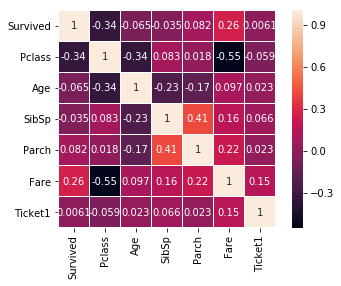

In [26]:
sns.heatmap(df.corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, linecolor='white', annot=True)

# Categorical features

In [27]:
categorical_features = ['Sex', 'Embarked', 'Parch']

In [28]:
df_dummies = pd.get_dummies(df, columns=categorical_features)
df_dummies.head()

,Survived,Pclass,Age,SibSp,Fare,Ticket1,Surname,Forename,Title,Sex_female,...,Embarked_C,Embarked_Q,Embarked_S,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,22.0,1,7.2500,2,BRAUND,OWEN HARRIS,MR,0,...,0,0,1,1,0,0,0,0,0,0
2,1,1,38.0,1,71.2833,2,CUMINGS,JOHN BRADLEY (FLORENCE BRIGGS THAYER),MRS,1,...,1,0,0,1,0,0,0,0,0,0
3,1,3,26.0,0,7.9250,2,HEIKKINEN,LAINA,MISS,1,...,0,0,1,1,0,0,0,0,0,0
4,1,1,35.0,1,53.1000,1,FUTRELLE,JACQUES HEATH (LILY MAY PEEL),MRS,1,...,0,0,1,1,0,0,0,0,0,0
5,0,3,35.0,0,8.0500,1,ALLEN,WILLIAM HENRY,MR,0,...,0,0,1,1,0,0,0,0,0,0


In [29]:
se = SumEncoder(include=categorical_features)
df_sum_encode = se.fit_transform(df, df.Survived) 
df_sum_encode_validation = se.transform(df_validation)
print(dict(df_sum_encode.isnull().sum()))
print(dict(df_sum_encode_validation.isnull().sum()))
df_validation[df_sum_encode_validation.Parch.isnull()]

TypeError: __init__() got an unexpected keyword argument 'include'

In [ ]:
def sum_coding(df_base, df, predictor, response='Survived'):
    df_grouped_sum = df_base.groupby(predictor)[response].sum()
    df_grouped_sum_scaled = df_grouped_sum / df_grouped_sum.max()
    return df[predictor].map(df_grouped_sum_scaled)

df_sum_encode = df.copy()
df_sum_encode_validation = df_validation.copy()
joined_df = df.append(df_validation)

for c_f in categorical_features:    
    df_sum_encode[c_f] = sum_coding(df, df_sum_encode, c_f)
    df_sum_encode_validation[c_f] = sum_coding(df, df_sum_encode_validation, c_f)
print(df_sum_encode.info())
print('-'*40)
print(df_sum_encode_validation.info())
df_sum_encode.head()

In [ ]:
df_sum_encode_validation.Parch = df_sum_encode_validation.Parch.fillna(0)

In [ ]:
sex_map = {'male' : 0, 'female' : 1}
embarked_map = {'C' : 0, 'Q' : 1, 'S' : 2}

df_order_coding = df.copy()
df_order_coding.Sex = df_order_coding.Sex.map(sex_map)
df_order_coding.Embarked = df_order_coding.Embarked.map(embarked_map)
df_order_coding.head()

# Data exploration

In [ ]:
df.Survived.value_counts().plot.bar()

In [ ]:
df_grouped_survived = df.groupby(['Survived', 'Sex'])
print(df_grouped_survived.sum())
df_grouped_survived.Age.plot.kde(legend=True)

In [ ]:
df["age_q"]= np.digitize(df.Age, range(0,50,5))
sns.factorplot(data=df,x='age_q', y='Survived',hue='Pclass', kind='bar',size=10)

In [ ]:
df[(df.Age > 65)].count()

In [ ]:
sns.factorplot(data=df,x='Sex',y='Age',hue='Survived', kind='box')

In [ ]:
def eval_model(models, df):
    response = ['Survived']
    features = list(set(df.columns) - set(response + ['PassengerId']))
    df = df.dropna()
    X = df[features]
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
    for name, model in models.items():
        print('~~~ {} '.format(name))
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_test)
        print(model.score(X_test, y_test))
        print(f1_score(y_test, y_pred))


models = { 
    'LogisticRegression' : LogisticRegression() ,
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    # 'SVC' : SVC(kernel='poly', gamma=3),
    'XGBClassifier' : xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
}

print('\n~~~ df_dummies ~~~~~~~~~~~ ')
eval_model(models, df_dummies)


print('\n~~~ df_order_coding ~~~~~~ ')
eval_model(models, df_order_coding)

print('\n~~~ df_sum_encode ~~~~~~~~ ')
eval_model(models, df_sum_encode)

In [30]:
features = list(set(df.columns) - set(['Survived', 'PassengerId']))
y_pred = models['GradientBoostingClassifier'].predict(df_sum_encode[features])


pd.DataFrame(confusion_matrix(df_sum_encode.Survived, y_pred) / len(df_sum_encode))

NameError: name 'models' is not defined

In [31]:
predictions = models['GradientBoostingClassifier'].predict(df_sum_encode_validation[features])
submission = pd.DataFrame({ 'PassengerId': df_validation['PassengerId'],
                            'Survived': predictions })
submission.to_csv('submission.csv', index=False)

NameError: name 'models' is not defined

In [23]:
def _(X):
    data = { c: X[c].value_counts().index[0] if X[c].dtype == np.dtype('O')  else X[c].median() 
                for c in X
           }
    return pd.Series(data, index=X.columns)
_(df[features].head())

Parch            0
Pclass           3
Embarked         S
SibSp            1
Fare          8.05
Age             35
Sex         female
dtype: object

In [45]:
pd.Series(pd.cut(df['Fare'], 5).unique()) # , [0, .25, 0.5, .75, .1])

0     (-0.512, 102.466]
1    (204.932, 307.398]
2    (102.466, 204.932]
3    (409.863, 512.329]
dtype: category
Categories (4, interval[float64]): [(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (409.863, 512.329]]